In [20]:
import glob
import matplotlib.pyplot as plt
import multiprocessing as mp
import seaborn as sns
import numpy as np
# np.random.seed(42)
import os
import pandas as pd

from utils.loading import TICKER_PATHS, BUYER_PATH, SELLER_PATH
from utils.loading import read_ticker
from utils.preprocessing import preprocess_ticker
from utils.processing import process_all_tickers, daily_vol

In [84]:
process_all_tickers(TICKER_PATHS)

ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/GCN.GO...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/IRC.CXC...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/SMM.GO...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/KRS.ALP...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/CFY.ALP...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/TE.ALP...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/LTG.ALP...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/WEY.V...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/GSW.GO...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/IZN.GO...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/HXC.ALP...
ERROR:root:Error processing 

In [85]:
buyer_files = glob.glob(os.path.join(BUYER_PATH, "*.parquet"))
seller_files = glob.glob(os.path.join(SELLER_PATH, "*.parquet"))

df_buyer = pd.concat((pd.read_parquet(f) for f in buyer_files))
df_seller = pd.concat((pd.read_parquet(f) for f in seller_files))

In [88]:
def volume_bins(df, num_bins = 100):
    df = df.copy()
    volume_bins = pd.qcut(df['volume_pct'], q=num_bins, duplicates='drop')
    binned_data = df.groupby(volume_bins)['price_impact_pct'].mean().reset_index(name='avg_price_impact')
    binned_data['volume_pct'] = binned_data['volume_pct'].apply(lambda x: x.mid)
    return binned_data

In [89]:
buyer_binned = volume_bins(df_buyer)
seller_binned = volume_bins(df_seller)

/var/folders/zm/2nqnsjy52f715x3n_9c2_pnh0000gn/T/ipykernel_1299/1016892627.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df.groupby(volume_bins)['price_impact_pct'].mean().reset_index(name='avg_price_impact')
/var/folders/zm/2nqnsjy52f715x3n_9c2_pnh0000gn/T/ipykernel_1299/1016892627.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df.groupby(volume_bins)['price_impact_pct'].mean().reset_index(name='avg_price_impact')


In [97]:
df_buyer

,volume_pct,price_impact_pct
0,1.000000,0.00
1,1.000000,0.00
2,0.333333,0.00
3,0.333333,0.00
4,0.333333,0.00
...,...,...
3033,0.057227,0.17
3034,0.001180,0.00
3035,0.035988,0.16
3036,0.015929,0.11


<Axes: ylabel='Frequency'>

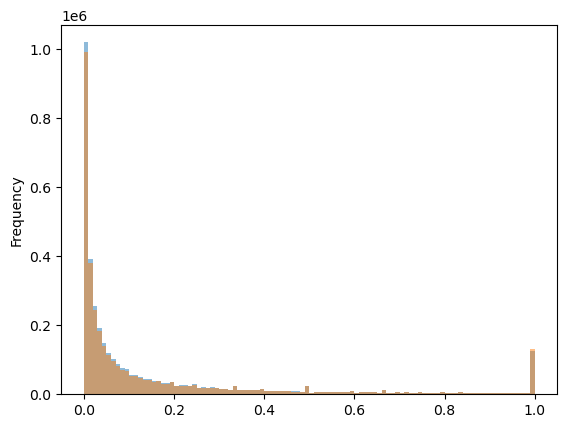

In [99]:
df_buyer['volume_pct'].plot.hist(bins=100, alpha=0.5)
df_seller['volume_pct'].plot.hist(bins=100, alpha=0.5)

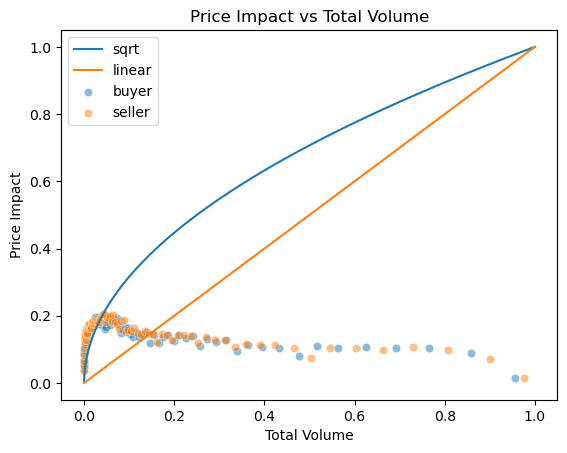

In [100]:
# plot price impact vs volume
# df_trader_stats = df_trader_stats[df_trader_stats['price_impact'] > 0]
# draw a square root line
x = np.logspace(-5, 0, 1000)
# create sqrt line with intercept 0.1
y_sqrt = np.sqrt(x)

plt.plot(x, y_sqrt, label='sqrt')
plt.plot(x, x, label='linear')
plt.legend()


sns.scatterplot(buyer_binned,
                x='volume_pct',
                y='avg_price_impact',
                label='buyer',
                alpha=0.5)
sns.scatterplot(seller_binned,
                x='volume_pct',
                y='avg_price_impact',
                label='seller',
                alpha=0.5)
# plt.loglog(df_seller['volume_pct'],
#            df_seller['price_impact_pct'],
#            label='seller',
#            alpha=0.5)
plt.xlabel('Total Volume')
plt.ylabel('Price Impact')
plt.title('Price Impact vs Total Volume')
plt.show()

In [ ]:
0.1 + np.sqrt(x), np.sqrt(x)

In [ ]:
trader_stats

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming df is your preprocessed DataFrame

# Aggregate data
aggregated_data = df_cleaned.resample('min').agg({
    'trade-volume': 'sum',
    'trade-price': lambda x: np.average(x, weights=df_cleaned.loc[x.index, 'trade-volume'])  # Weighted average
})

# Calculate price changes
aggregated_data['price_change'] = aggregated_data['trade-price'].diff().abs()

# Square root of trade volume
aggregated_data['sqrt_volume'] = np.sqrt(aggregated_data['trade-volume'])

# Linear regression
X = sm.add_constant(aggregated_data['sqrt_volume'])  # Add constant term
y = aggregated_data['price_change']
model = sm.OLS(y, X, missing='drop').fit()  # Drop NaN values

# Plotting
plt.scatter(aggregated_data['sqrt_volume'], aggregated_data['price_change'])
plt.plot(aggregated_data['sqrt_volume'], model.predict(X), color='red')  # Regression line
plt.xlabel('Square Root of Trade Volume')
plt.ylabel('Absolute Price Change')
plt.show()

# Output model summary
print(model.summary())
